In [1]:

import yaml
from train_eval.trainer import Trainer
from torch.utils.tensorboard import SummaryWriter
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "6"


2022-12-01 00:19:00,037	INFO worker.py:1518 -- Started a local Ray instance.


In [3]:
with open("/home/stanliu/code/pgp/PGP/configs/raster.yml", 'r') as yaml_file:
    cfg = yaml.safe_load(yaml_file)

In [4]:
ds_type = cfg['dataset'] + '_' + cfg['agent_setting'] + '_' + cfg['input_representation']
cfg['train_set_args']

{'split': 'train',
 't_h': 2,
 't_f': 6,
 'map_extent': [-50, 50, -20, 80],
 'img_size': [400, 400],
 'polyline_resolution': 1,
 'polyline_length': 20,
 'traversal_horizon': 15,
 'random_flips': True}

In [5]:
trainer = Trainer(cfg, "/home/stanliu/data/mnt/nuScenes/", "/home/stanliu/code/pgp/PGP/preprocess_raster")

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 40.672 seconds.
Reverse indexing ...
Done reverse indexing in 12.2 seconds.


In [6]:
for i,data in enumerate(trainer.tr_dl):
    data_test=data['inputs']
    break


In [14]:
print(data_test.keys())

dict_keys(['instance_token', 'sample_token', 'map_representation', 'surrounding_agent_representation', 'target_agent_representation'])

In [2]:
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.nuscenes import NuScenes
map_extent=[ -50, 50, -20, 80 ]
img_size=[400,400]
resolution = (map_extent[1] - map_extent[0]) /  img_size[1]
nusc = NuScenes(version='v1.0-trainval', dataroot="/home/stanliu/data/mnt/nuScenes/", verbose=True)
helper=PredictHelper(nusc)
map_rasterizer = StaticLayerRasterizer(helper,
                                        resolution=resolution,
                                        meters_ahead=map_extent[3],
                                        meters_behind=-map_extent[2],
                                        meters_left=-map_extent[0],
                                        meters_right=map_extent[1])

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 38.944 seconds.
Reverse indexing ...
Done reverse indexing in 9.8 seconds.


In [18]:
from nuscenes.prediction.input_representation.static_layers import *
import matplotlib.pyplot as plt
import numpy as np
idx=1
instance_token=data_test['instance_token'][idx]
sample_token = data_test['sample_token'][idx]



sample_annotation = map_rasterizer.helper.get_sample_annotation(instance_token, sample_token)
map_name = map_rasterizer.helper.get_map_name_from_sample_token(sample_token)

x, y = sample_annotation['translation'][:2]

yaw = quaternion_yaw(Quaternion(sample_annotation['rotation']))

yaw_corrected = correct_yaw(yaw)

image_side_length = 2 * max(map_rasterizer.meters_ahead, map_rasterizer.meters_behind,
                            map_rasterizer.meters_left, map_rasterizer.meters_right)
image_side_length_pixels = int(image_side_length / map_rasterizer.resolution)
   
patchbox = get_patchbox(x, y, image_side_length)

angle_in_degrees = angle_of_rotation(yaw_corrected) * 180 / np.pi

canvas_size = (image_side_length_pixels, image_side_length_pixels)

masks = map_rasterizer.maps[map_name].get_map_mask(patchbox, angle_in_degrees, map_rasterizer.layer_names, canvas_size=canvas_size)
## Get drivable area mask
mask_drivable_area=masks[0]

images = []
for mask, color in zip(masks, map_rasterizer.colors):
    images.append(change_color_of_binary_mask(np.repeat(mask[::-1, :, np.newaxis], 3, 2), color))

lanes = draw_lanes_in_agent_frame(image_side_length_pixels, x, y, yaw, radius=50,
                                    image_resolution=map_rasterizer.resolution, discretization_resolution_meters=1,
                                    map_api=map_rasterizer.maps[map_name])

images.append(lanes)

image = map_rasterizer.combinator.combine(images)

row_crop, col_crop = get_crops(map_rasterizer.meters_ahead, map_rasterizer.meters_behind, map_rasterizer.meters_left,
                                map_rasterizer.meters_right, map_rasterizer.resolution,
                                int(image_side_length / map_rasterizer.resolution))

/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/stanliu/.local/lib/python3.7/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


In [41]:
map_rasterizer.resolution

0.25

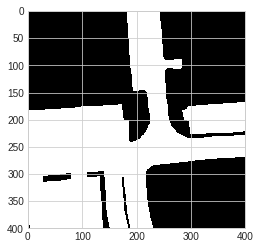

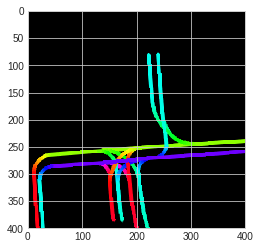

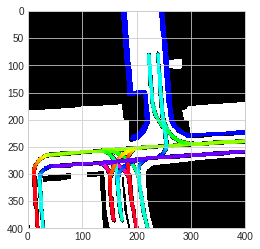

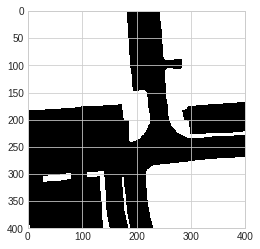

In [35]:
plt.imshow(images[0][row_crop, col_crop, :])
plt.show()
plt.imshow(lanes[row_crop, col_crop, :])
plt.show()
plt.imshow(image[row_crop, col_crop, :])
plt.show()
plt.imshow(images[0][row_crop, col_crop, 2]/255)


In [24]:
data_test['map_representation'][0].shape

torch.Size([32, 3, 400, 400])

In [11]:
target_agent_representation = data_test['target_agent_representation']
surrounding_agent_representation = data_test['surrounding_agent_representation']
map_representation = data_test['map_representation'][0]
mask= data_test['map_representation'][1]

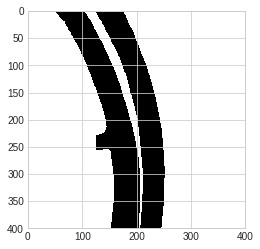

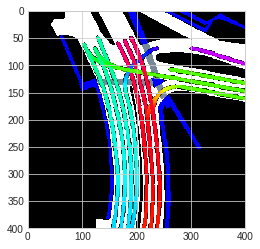

In [12]:

plt.imshow(np.array(mask[idx]))
plt.show()
plt.imshow(np.array(map_representation[idx]).transpose(1,2,0))